In [1]:
import torch
import time
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data_utils

from skimage import io

# interactive mode
plt.ion()

## Set parameters

In [2]:
use_gpu = torch.cuda.is_available()

## Load data

### load images

In [3]:
# train_images.size() == [200, 360, 338]  
# val_images.size() == [100, 360, 338]
pattern = 'data/bmc{}.bmp'
X = np.array([io.imread(pattern.format(i + 1)) for i in range(300)], dtype=np.float32)
X = X[:, np.newaxis, ...]
X_mean, X_std = np.mean(X), np.std(X)
X = (X - X_mean) / X_std
X_train, X_val = torch.split(torch.FloatTensor(X), 200)

### load targets

In [4]:
y_train, y_val = [torch.unsqueeze(torch.FloatTensor(np.load('y_' + mode + '.npy')), 1)
                  for mode in ['train', 'val']]


### fit into loaders

In [5]:
dsets = {mode: data_utils.TensorDataset(eval('X_' + mode), eval('y_' + mode))
         for mode in ['train', 'val']}
dset_loaders = {mode: data_utils.DataLoader(dsets[mode], batch_size=32, shuffle=True, num_workers=16)
                for mode in ['train', 'val']}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}

## Visualize a few images

In [6]:
def snapshots(inputs, targets, rows=3, cols=3, step=3):
    
    # compute intervals
    depth = inputs.shape[0]
    begin = depth // 2 - step * (rows * cols // 2)
    
    fig, ax = plt.subplots(rows, cols, figsize=[rows*2, cols*2])
    for i in range(rows * cols):
        idx = begin + i * step
        ax[i // rows, i % rows].set_title('angle %5.2f' % targets[idx, 0])
        ax[i // rows, i % rows].imshow(inputs[idx, 0], cmap='gray')
        ax[i // rows, i % rows].axis('off')
    plt.show()

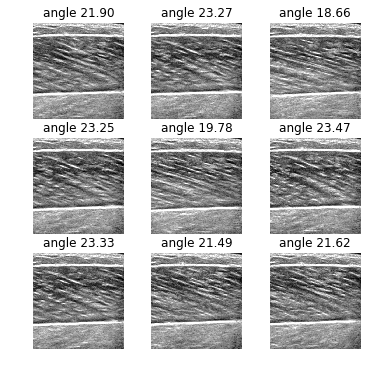

In [7]:
# Get a batch of training data
inputs, targets = next(iter(dset_loaders['train']))

# Make a grid from batch
snapshots(inputs.numpy(), targets)

## Training the model

In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [9]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]

            epoch_loss = running_loss / dset_sizes[phase]
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model

### learning rate scheduler

In [10]:
def exp_lr_scheduler(optimizer, epoch, init_lr=1e-4, lr_decay_epoch=20):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

### finetuning the convnet

In [11]:
model = torchvision.models.resnet18(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_bottleneck = model.fc.in_features
model.fc = nn.Linear(num_bottleneck, 1)    

if use_gpu:
    model = model.cuda()

criterion = nn.MSELoss()

ignored_params = list(map(id, model.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     model.parameters())

optimizer = optim.SGD([
            {'params': base_params},
            {'params': model.fc.parameters(), 'lr': 1e-5}
            ], lr=1e-4, momentum=0.9)

### train and evaluate

In [12]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
LR is set to 0.0001
train Loss: 6.5282
val Loss: 0.6873

Epoch 1/99
----------
train Loss: 0.4943
val Loss: 0.3243

Epoch 2/99
----------
train Loss: 0.1111
val Loss: 0.0990

Epoch 3/99
----------
train Loss: 0.0600
val Loss: 0.0728

Epoch 4/99
----------
train Loss: 0.0445
val Loss: 0.0554

Epoch 5/99
----------
train Loss: 0.0214
val Loss: 0.0362

Epoch 6/99
----------
train Loss: 0.0182
val Loss: 0.0278

Epoch 7/99
----------
train Loss: 0.0091
val Loss: 0.0396

Epoch 8/99
----------
train Loss: 0.0065
val Loss: 0.0294

Epoch 9/99
----------
train Loss: 0.0039
val Loss: 0.0492

Epoch 10/99
----------
train Loss: 0.0048
val Loss: 0.0275

Epoch 11/99
----------
train Loss: 0.0012
val Loss: 0.0496

Epoch 12/99
----------
train Loss: 0.0055
val Loss: 0.0407

Epoch 13/99
----------
train Loss: 0.0039
val Loss: 0.0360

Epoch 14/99
----------
train Loss: 0.0022
val Loss: 0.0450

Epoch 15/99
----------
train Loss: 0.0028
val Loss: 0.0397

Epoch 16/99
----------
train L

## Save model

In [13]:
torch.save(model_ft, 'model.pt')

## Inference

In [14]:
def image_loader(index):
    """load image, returns cuda tensor"""
    image = np.array([io.imread(pattern.format(index + 1))], dtype=np.float32)
    image = (image - X_mean) / X_std
    image = Variable(torch.FloatTensor(image), requires_grad=True)
    image = image.unsqueeze(0)
    return image.cuda()  #assumes using GPU

In [15]:
pa_res = np.zeros([500, 1])

for i in range(500):
    res = model_ft(image_loader(i))
    pa_res[i] = res.data.cpu().numpy()[0][0]

### smooth curve

In [16]:
from scipy.signal import savgol_filter
pa_smoothed = savgol_filter(pa_res.squeeze(), 23, 2)

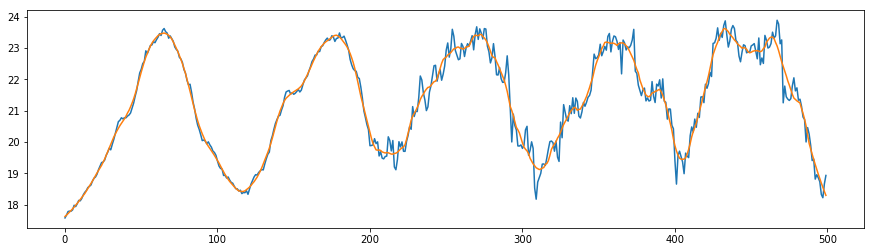

In [17]:
plt.figure(figsize=(15, 4))
plt.plot(range(500), pa_res, range(500), pa_smoothed);

## Compare with `fem.mat`

In [18]:
import scipy.io as sio

force, time = [sio.loadmat('data/fem.mat')[key].squeeze() for key in ['force', 'time2']]

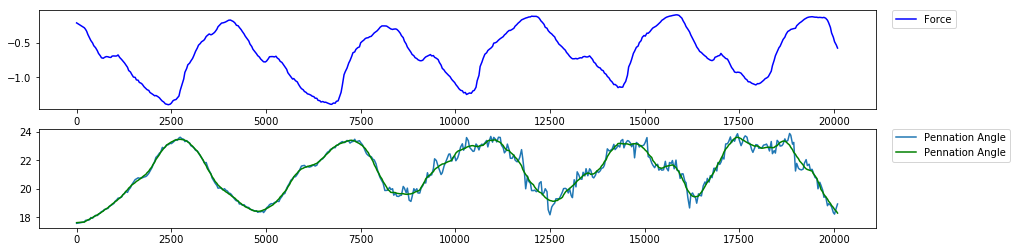

In [19]:
plt.figure(figsize=(15, 4))

plt.subplot(211)
plt.plot(time, force, 'b-', label='Force')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.subplot(212)
plt.plot(time, pa_res, time, pa_smoothed, 'g-', label='Pennation Angle');
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)

plt.show()

## Discussion

1. A good chance to practice PyTorch, actually it's the first time I use it. Compared to TensorFlow, PyTorch is so  intuitive, linear in thought and easy to use! 2017 is the year of PyTorch...
2. Because I use part of data to train (finetune) the `ResNet` Model, so the beginning part of curve is accurate while the end has some noise.
3. The labels used for training may not be precise, so this approach still has some improvements.